In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import tensorflow as tf

In [26]:
df = pd.read_csv('Preprocess_Reviews.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,neg,neu,pos,compound
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel lucky found used phone u used hard phone ...,1.0,positive,0.100,0.592,0.308,0.8966
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,positive,0.155,0.445,0.400,0.8548
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,pleased,0.0,positive,0.000,0.000,1.000,0.4404
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,work good go slow sometimes good phone love,0.0,positive,0.000,0.333,0.667,0.8750
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,positive,0.103,0.714,0.183,0.4215


In [27]:
#Drop unnecessary columns:
df = df.drop(['Product Name', 'Price', 'Review Votes', 'Brand Name'], axis=1)
df.dropna(inplace=True)

In [28]:
df_Positive = df[df['sentiment'] == 'positive'][0:20000]
df_Neutral = df[df['sentiment'] == 'neutral']
df_Negative = df[df['sentiment'] == 'negative']

In [29]:
df_Neutral_over = df_Neutral.sample(20000, replace=True)
df_Negative_over = df_Negative.sample(20000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [30]:
df

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215
...,...,...,...,...,...,...,...
154040,1,g international version great one messed korea...,negative,0.079,0.762,0.159,0.6948
124022,1,nit expected,negative,0.000,1.000,0.000,0.0000
234882,1,lost delivery,negative,0.697,0.303,0.000,-0.3182
118268,1,dosent work month,negative,0.000,1.000,0.000,0.0000


In [31]:
# Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

In [32]:
# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

In [33]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Reviews'], y, test_size=0.2, random_state=42)

In [34]:
# Load the Universal Sentence Encoder from TensorFlow Hub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, dtype=tf.string, input_shape=[], name='use_layer')

In [51]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [52]:
class UniversalSentenceEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, name="use_layer")

    def call(self, inputs):
        return self.use_layer(inputs)

# Input layer
input_text = Input(shape=(), dtype=tf.string, name='text_input')

# Universal Sentence Encoder layer
embedding = UniversalSentenceEncoderLayer()(input_text)

# Dense layers
dense1 = Dense(256, activation='relu')(embedding)
dropout1 = Dropout(0.5)(dense1)
batch_norm1 = BatchNormalization()(dropout1)
dense2 = Dense(128, activation='relu')(batch_norm1)
dropout2 = Dropout(0.5)(dense2)
batch_norm2 = BatchNormalization()(dropout2)
dense3 = Dense(64, activation='relu')(batch_norm2)
dropout3 = Dropout(0.5)(dense3)
output = Dense(num_classes, activation='softmax')(dropout3)

In [53]:
# Build the model
model = Model(inputs=[input_text], outputs=[output])

In [54]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ universal_sentence_encoder_layer_1   │ (None, 512)                 │               0 │
│ (UniversalSentenceEncoderLayer)      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,211 (680.51 KB)

 Trainable params: 173,443 (677.51 KB)

 Non-trainable params: 768 (3.00 KB)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
epochs = 20
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.5165 - loss: 1.0991 - val_accuracy: 0.6737 - val_loss: 0.8192
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.6750 - loss: 0.7311 - val_accuracy: 0.7184 - val_loss: 0.6507
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7001 - loss: 0.6852 - val_accuracy: 0.7317 - val_loss: 0.6163
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7194 - loss: 0.6454 - val_accuracy: 0.7426 - val_loss: 0.5919
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.7348 - loss: 0.6200 - val_accuracy: 0.7539 - val_loss: 0.5701
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7492 - loss: 0.5919 - val_accuracy: 0.7635 - val_loss: 0.5507
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7598 - loss: 0.5695 - val_accuracy: 0.7749 - val_loss: 0.5385
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7697 - loss: 0.5537 - 

In [57]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8360 - loss: 0.4330
Validation Loss: 0.4404
Validation Accuracy: 0.8335


In [58]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

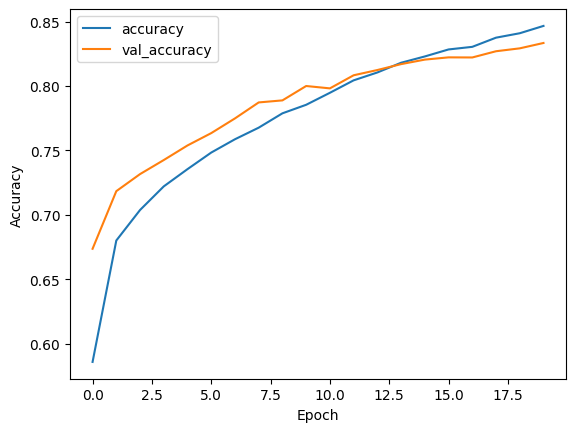

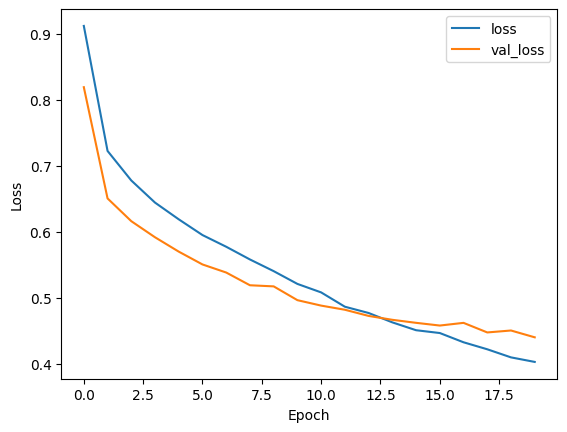

In [59]:
# Plot accuracy and loss
plot_history(history)

In [61]:
import numpy as np

# Example of making predictions
new_reviews = ["This phone is great!", "I do not like this product."]

# Convert list to a NumPy array
new_reviews_np = np.array(new_reviews, dtype=object)[:, np.newaxis]

# Make predictions
predictions = model.predict(new_reviews_np)

# Decode predictions
predicted_labels = label_encoder.inverse_transform([np.argmax(pred) for pred in predictions])

for review, sentiment, confidence in zip(new_reviews, predicted_labels, predictions):
    print(f'Review: {review} | Predicted Sentiment: {sentiment} | Confidence: {max(confidence):.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Review: This phone is great! | Predicted Sentiment: positive | Confidence: 0.9306
Review: I do not like this product. | Predicted Sentiment: negative | Confidence: 0.8782
